# Analysis with CSV Extracts

In [1]:
# Step 1: Import Necessary Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Step 2: Load Data
conditions_path = "/home/cdsw/exported-data/hl7_condition.csv"
claims_path = "/home/cdsw/exported-data/hl7_claims.csv"
careteam_path = "/home/cdsw/exported-data/hl7_careteam.csv"
benefits_path = "/home/cdsw/exported-data/hl7_benefits.csv"

conditions_df = pd.read_csv(conditions_path, quotechar='"')
claims_df = pd.read_csv(claims_path, quotechar='"')
careteam_df = pd.read_csv(careteam_path, quotechar='"')
benefits_df = pd.read_csv(benefits_path, quotechar='"')

# Step 3: Data Preprocessing
# Example: Standardize column names, handle missing data, etc.
def preprocess_data(df):
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].str.strip('"')
    return df

conditions_df = preprocess_data(conditions_df)
claims_df = preprocess_data(claims_df)
careteam_df = preprocess_data(careteam_df)
benefits_df = preprocess_data(benefits_df)

# Print column names to identify the correct merging keys
print("Columns in conditions_df:", conditions_df.columns)
print("Columns in claims_df:", claims_df.columns)


Columns in conditions_df: Index(['fullurl', 'condition_id', 'clinical_status', 'verification_status',
       'condition_category', 'condition_code', 'condition_display',
       'condition_text', 'subject_reference', 'encounter_reference',
       'onsetdatetime', 'recordeddate', 'filename'],
      dtype='object')
Columns in claims_df: Index(['item_sequence', 'product_service_code', 'product_service_display',
       'product_service_text', 'net_value', 'net_currency',
       'encounter_reference', 'diagnosis_sequence', 'filename', 'fullurl',
       'claim_id', 'status', 'claim_type', 'use', 'patient_reference',
       'patient_display', 'provider_reference', 'provider_display',
       'billable_period_start', 'billable_period_end', 'created',
       'total_value', 'total_currency'],
      dtype='object')


count                              379
mean     2006-06-11 19:21:59.622691328
min                1940-09-04 07:50:00
25%                1991-11-17 08:17:24
50%                2015-10-25 19:58:41
75%                2020-05-13 12:16:16
max                2024-03-23 01:24:32
Name: created, dtype: object
count                              379
mean     2006-06-11 18:36:03.496042368
min                1940-09-04 06:56:35
25%                1991-11-17 07:28:01
50%                2015-10-25 19:19:04
75%                2020-05-13 11:21:09
max                2024-03-23 00:34:37
Name: onsetdatetime, dtype: object
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
Name: days_until_claim, dtype: int64


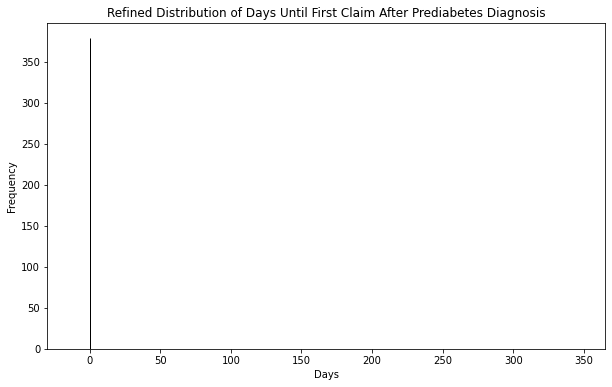

In [26]:
# Step 3: Data Preprocessing
# Convert date columns to datetime objects and fill missing values
conditions_df['onsetdatetime'] = pd.to_datetime(conditions_df['onsetdatetime'], errors='coerce', format='%Y-%m-%dT%H:%M:%S%z')
conditions_df['recordeddate'] = pd.to_datetime(conditions_df['recordeddate'], errors='coerce', format='%Y-%m-%dT%H:%M:%S%z')

# Rename 'subject_reference' in conditions_df to 'patient_reference' to match claims_df for merging
conditions_df.rename(columns={'subject_reference': 'patient_reference'}, inplace=True)

# Filter for Prediabetes conditions
prediabetes_df = conditions_df[conditions_df['condition_display'].str.contains("Prediabetes", na=False)]

# Step 4: Analysis of Follow-up Encounters
# Merge conditions with claims to see follow-up treatments (ensure merge keys are correctly set)
prediabetes_claims_df = pd.merge(prediabetes_df, claims_df, on="patient_reference", how="left")
# prediabetes_claims_df['created'] = pd.to_datetime(prediabetes_claims_df['created'], errors='coerce', format='%Y-%m-%d')

# Convert both datetime columns to the same timezone setting, either both naive or both aware
# Convert 'created' column to datetime without specifying the format
# Pandas will infer the ISO 8601 format correctly
prediabetes_claims_df['created'] = pd.to_datetime(prediabetes_claims_df['created'], errors='coerce')

# If you want to remove the timezone information and make the datetime objects naive
prediabetes_claims_df['created'] = prediabetes_claims_df['created'].dt.tz_localize(None)

# Make sure 'onsetdatetime' is also timezone-naive
prediabetes_claims_df['onsetdatetime'] = pd.to_datetime(prediabetes_claims_df['onsetdatetime'], errors='coerce').dt.tz_localize(None)

# Now both columns are timezone-naive and you can calculate the difference
prediabetes_claims_df['days_until_claim'] = (prediabetes_claims_df['created'] - prediabetes_claims_df['onsetdatetime']).dt.days


# # Visualize the distribution of days until first claim
# plt.figure(figsize=(10, 6))
# sns.histplot(prediabetes_claims_df['days_until_claim'].dropna(), bins=30, kde=True)
# plt.title('Distribution of Days Until First Claim After Prediabetes Diagnosis')
# plt.xlabel('Days')
# plt.ylabel('Frequency')
# plt.show()

# Check the range of dates in the 'created' and 'onsetdatetime' columns
print(prediabetes_claims_df['created'].describe())
print(prediabetes_claims_df['onsetdatetime'].describe())

# Inspect the first few rows of the calculated 'days_until_claim' to ensure they are sensible
print(prediabetes_claims_df['days_until_claim'].head(20))

# Plot a detailed histogram
plt.figure(figsize=(10, 6))
sns.histplot(prediabetes_claims_df.loc[prediabetes_claims_df['days_until_claim'].notnull(), 'days_until_claim'], bins=50, kde=True)
plt.title('Refined Distribution of Days Until First Claim After Prediabetes Diagnosis')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.xlim(-30, 365)  # Adjust the range as needed to focus on the most relevant data
plt.show()
